In [6]:
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import balanced_accuracy_score
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings("ignore")
import data_prep

In [56]:
#Figure formattings
font = {'family' : 'serif',
        'size'   : 15}

plt.rc('font', **font)
plt.rc('lines', linewidth=3)
plt.rc('axes', linewidth=3)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)

In [58]:
machine_name = 'Theta'

In [60]:
X_train, y_train, X_test, y_test, X_eval, y_eval, y_train_log, y_eval_log, y_test_log, y_train_without_outliers, X_train_without_outliers, X_train_reduced, X_test_reduced, X_eval_reduced, X_train_class, y_train_class,X_test_class,y_test_class, X_eval_class, y_eval_class, X_train_class_reduced, y_train_class_reduced, X_test_class_reduced, y_test_class_reduced, X_eval_class_reduced, y_eval_class_reduced = data_prep.load_parse_final_data(machine_name)
print(X_train_reduced.shape)
print(X_eval_reduced.shape)
print(X_test_reduced.shape)

print(y_train_log.shape)
print(y_train_without_outliers.shape) 


(286324, 1)
(281133, 17)
(95442, 17)
(95442, 17)
(286324, 1)
(281133, 1)


In [23]:
#model training, evaluation and testing is done using:
#1. Data to which outlier removal and PCA had been applied (X_train_reduced, X_eval_reduced, X_test_reduced)
#2. Data without outlier removal and PCA (X_train, X_eval, X_test)

# Hyperparameter tunning

In [25]:
# Tune hyperparameter with random search
# Number of trees in random forest
n_estimators = [100,200,300,400,500]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,15,20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [ 2,3, 4,6,10,15]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['log2', 'sqrt'], 'min_samples_split': [2, 5, 10, 15, 20], 'min_samples_leaf': [2, 3, 4, 6, 10, 15], 'bootstrap': [True, False]}


In [29]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 5, verbose=2, random_state=42)
rf_random.fit(X_train, y_train_log)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END bootstrap=True, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=  20.9s
[CV] END bootstrap=True, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=  20.7s
[CV] END bootstrap=True, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=  20.5s
[CV] END bootstrap=True, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=  20.0s
[CV] END bootstrap=True, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=  19.9s
[CV] END bootstrap=False, max_features=log2, min_samples_leaf=10, min_samples_split=15, n_estimators=500; total time= 2.6min
[CV] END bootstrap=False, max_features=log2, min_samples_leaf=10, min_samples_split=15, n_estimators=500; total time= 2.6min
[CV] END bootstrap=False, max_features=log2, min_samples_leaf=10, mi

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [2, 3, 4, 6, 10,
                                                             15],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=2)

In [30]:
print(rf_random.best_params_)

{'n_estimators': 500, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}


In [31]:
#Train with hyperparameters from random search, try various max_depth/tree_depth values
best_params = rf_random.best_params_
# List of tree_depth values to test
max_depth = [5,10, 15, 20, 50, 100]
# Containers to store results
rf_train_times = []
rf_predict_times = []
#training results
rf_r2_scores_train = []
rf_rmse_train = []
rf_mae_train = []
rf_mape_train = []
#evaluation results
rf_r2_scores_eval = []
rf_rmse_eval = []
rf_mae_eval = []
rf_mape_eval = []

#RF model training function
def rf_train(X, y):

    # Loop through each max_depth value
    for depth in max_depth:
        print(f"\nTraining RandomForestRegressor with tree_depth = {depth}")
        best_params['max_depth'] = depth
        rf = RandomForestRegressor(**best_params)

        # Training
        start_train = time.time()
        rf.fit(X, y) #log transformed (np.log(y+1)) target to reduce skewness
        end_train = time.time()
        train_duration = end_train - start_train
        # Print time taken to train model
        rf_train_times.append(train_duration)
        print(f"Training time: {train_duration:.2f} seconds")
    
        # Prediction on evaluation set
        start_test = time.time()
        y_pred_log = rf.predict(X_eval)
        end_test = time.time()
        predict_duration = end_test - start_test
        rf_predict_times.append(predict_duration)
        # Print prediction time
        print(f"Prediction time: {predict_duration:.2f} seconds")

        # Evaluate on evaluation data
        y_pred = np.expm1(y_pred_log)
        r2_eval = r2_score(y_eval,y_pred)
        rmse_eval = np.sqrt(mean_squared_error(y_eval, y_pred))
        mae_eval = mean_absolute_error(y_eval, y_pred)
        mape_eval = mean_absolute_percentage_error(y_eval, y_pred)
    
        rf_r2_scores_eval.append(r2_eval)
        rf_rmse_eval.append(rmse_eval)
        rf_mae_eval.append(mae_eval)
        rf_mape_eval.append(mape_eval)
        print(f"  R2_Score_Eval: {r2_eval:.2f}")
        print(f"  RMSE_Eval: {rmse_eval:.2f}")
        print(f"  MAE_Eval: {mae_eval:.2f}")
        print(f"  MAPE_Eval: {mape_eval:.2f}")

        # Prediction on training set
        y_train_pred_log = rf.predict(X_train)
        # Evaluate on training data
        y_train_pred = np.expm1(y_train_pred_log)
        r2_train = r2_score(y_train,y_train_pred)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
    
        rf_r2_scores_train.append(r2_train)
        rf_rmse_train.append(rmse_train)
        rf_mae_train.append(mae_train)
        rf_mape_train.append(mape_train)
        print("***Evaluation on training set***")
        print(f"  R2_Score_Train: {r2_train:.2f}")
        print(f"  RMSE_Train: {rmse_train:.2f}")
        print(f"  MAE_Train: {mae_train:.2f}")
        print(f"  MAPE_Train: {mape_train:.2f}")

        #return values
    return rf_r2_scores_train, rf_r2_scores_eval
rf_train(X_train, y_train_log)   


Training RandomForestRegressor with tree_depth = 5
Training time: 69.55 seconds
Prediction time: 1.47 seconds
  R2_Score_Eval: 0.12
  RMSE_Eval: 31.88
  MAE_Eval: 6.06
  MAPE_Eval: 24.76
***Evaluation on training set***
  R2_Score_Train: 0.12
  RMSE_Train: 31.57
  MAE_Train: 6.02
  MAPE_Train: 24.93

Training RandomForestRegressor with tree_depth = 10
Training time: 131.29 seconds
Prediction time: 3.17 seconds
  R2_Score_Eval: 0.32
  RMSE_Eval: 28.05
  MAE_Eval: 5.17
  MAPE_Eval: 17.33
***Evaluation on training set***
  R2_Score_Train: 0.35
  RMSE_Train: 27.14
  MAE_Train: 5.06
  MAPE_Train: 17.09

Training RandomForestRegressor with tree_depth = 15
Training time: 181.59 seconds
Prediction time: 5.89 seconds
  R2_Score_Eval: 0.54
  RMSE_Eval: 23.01
  MAE_Eval: 4.25
  MAPE_Eval: 12.94
***Evaluation on training set***
  R2_Score_Train: 0.66
  RMSE_Train: 19.66
  MAE_Train: 3.74
  MAPE_Train: 10.96

Training RandomForestRegressor with tree_depth = 20
Training time: 223.37 seconds
Predict

([0.11918413773683245,
  0.34876273569934035,
  0.6584773339549002,
  0.7593768585024747,
  0.7771787007599629,
  0.7755339512118112],
 [0.1162973293288625,
  0.31589767628203824,
  0.5395395319310783,
  0.602478307565643,
  0.6167423970989279,
  0.6145262926927149])

In [43]:
# Select best max_depth based on r2 score on evaluation data, and that the difference between the r2 score on 
# evaluation data and training data does not exceed 0.20

# Convert to numpy array
rf_r2_scores_train = np.array(rf_r2_scores_train)
rf_r2_scores_eval = np.array(rf_r2_scores_eval)

# Compute difference between rf_r2_scores_train and rf_r2_scores_eval
r2_diff = rf_r2_scores_train - rf_r2_scores_eval
# Filter acceptable depths(difference <= 0.20)
valid_mask = r2_diff <= 0.20

if not np.any(valid_mask):
    print("No depths satisfy the overfitting constraint (train - eval <= 0.20).")
    print("Selecting the best depth purely based on evaluation score.")
    best_depth_index = np.argmax(rf_r2_scores_eval)
else:
    # Among valid depths, choose the one with highest eval R²
    best_depth_index = np.argmax(rf_r2_scores_eval[valid_mask])
    valid_depths = np.array(max_depth)[valid_mask]
    optimal_depth = valid_depths[best_depth_index]

print(f"\nBest max_depth that satisfies constraint: {optimal_depth}")

# Final model training with best depth
print("\nRetraining on full training data with best max_depth and evaluating on test data...")
best_params['max_depth'] = optimal_depth
final_model = RandomForestRegressor(**best_params)
final_model.fit(X_train, y_train_log)

# Test prediction
y_test_pred_log = final_model.predict(X_test)
y_test_pred = np.expm1(y_test_pred_log)

# Test performance
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print("\nFinal Test Set Performance:")
print(f"  R2 Score: {r2_test:.2f}")
print(f"  RMSE: {rmse_test:.2f}")
print(f"  MAE: {mae_test:.2f}")
print(f"  MAPE: {mape_test:.2f}")


Best max_depth that satisfies constraint: 50

Retraining on full training data with best max_depth and evaluating on test data...

Final Test Set Performance:
  R2 Score: 0.53
  RMSE: 27.55
  MAE: 3.74
  MAPE: 10.52


# XGBOOST

In [10]:
from xgboost import XGBRegressor
# Define the hyperparameter grid for randomized search
random_grid = {
    'n_estimators': [1000, 2000, 3000, 5000],
    'learning_rate': [0.01, 0.03, 0.05],
    'min_child_weight': [1, 3, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [1, 5, 10, 20]
}


print("Random Search Hyperparameter Grid for XGB:")
print(random_grid)

Random Search Hyperparameter Grid for XGB:
{'n_estimators': [1000, 2000, 3000, 5000], 'learning_rate': [0.01, 0.03, 0.05], 'min_child_weight': [1, 3, 5, 10], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.4, 0.6, 0.8, 1.0], 'gamma': [0, 0.1, 0.3, 0.5], 'reg_alpha': [0, 0.1, 1, 10], 'reg_lambda': [1, 5, 10, 20]}


In [22]:
# Instantiate the model
xgb = XGBRegressor(tree_method="hist")
# Perform randomized search with 5-fold cross-validation
xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=random_grid,
    n_iter=20,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit to training data
xgb_random.fit(X_train, y_train_log)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.4, 0.6, 0.8,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.3, 0.5],
                                        'learning_rate': [0.01, 0.03, 0.05],
                                        'min_child_weight': [1, 3, 5, 10],
                                        'n_estimators': [1000, 2000, 3000,
                                                         5000],
                                        'reg_alpha': [0, 0.1, 1, 10],
                                        'reg_lambda': [1, 5, 10, 20],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, verbose=2)

In [12]:
print(xgb_random.best_params_)

In [14]:
#Train with hyperparameters from random search, with different tree depths
# List of max_depth values to test
max_depth_values = [5,10, 15, 20, 50, 100]

# Containers to store results
xgb_train_times = []
xgb_predict_times = []
#training results
xgb_r2_scores_train = []
xgb_rmse_train = []
xgb_mae_train = []
xgb_mape_train = []
#evaluation results
xgb_r2_scores_eval = []
xgb_rmse_eval = []
xgb_mae_eval = []
xgb_mape_eval = []

def xgb_train(X,y):
    # Loop through each max_depth value
    for depth in max_depth_values:
        print(f"\nTraining XGBRegressor with max_depth = {depth}")
        best_params['max_depth'] = depth
        xgb = XGBRegressor(**best_params, tree_method="hist", early_stopping_rounds=50)

        # Training
        start_train = time.time()
        xgb.fit(X, y, eval_set=[(X_eval, y_eval_log)],
        verbose=False)
        end_train = time.time()
        train_duration = end_train - start_train
        # Print time taken to train model
        xgb_train_times.append(train_duration)
        print(f"Training time: {train_duration:.2f} seconds")

        # Prediction on evaluation set
        start_test = time.time()
        y_pred_log = xgb.predict(X_eval)
        end_test = time.time()
        predict_duration = end_test - start_test
        xgb_predict_times.append(predict_duration)
        # Print prediction time
        print(f"Prediction time: {predict_duration:.2f} seconds")
    
        # Evaluate on evaluation data
        y_pred = np.expm1(y_pred_log)
        r2_eval = r2_score(y_eval, y_pred)
        rmse_eval = np.sqrt(mean_squared_error(y_eval, y_pred))
        mae_eval = mean_absolute_error(y_eval, y_pred)
        mape_eval = mean_absolute_percentage_error(y_eval, y_pred)

        xgb_r2_scores_eval.append(r2_eval)
        xgb_rmse_eval.append(rmse_eval)
        xgb_mae_eval.append(mae_eval)
        xgb_mape_eval.append(mape_eval)
        print("*** Evaluation set ***")
        print(f"  R2 Score: {r2_eval:.2f}")
        print(f"  RMSE: {rmse_eval:.2f}")
        print(f"  MAE: {mae_eval:.2f}")
        print(f"  MAPE: {mape_eval:.2f}")

        # Prediction on training set
        y_train_pred_log_xgb = xgb.predict(X_train)
        # Evaluate on training data
        y_train_pred_xgb = np.expm1(y_train_pred_log_xgb)
        r2_train_xgb = r2_score(y_train,y_train_pred_xgb)
        rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
        mae_train_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
        mape_train_xgb = mean_absolute_percentage_error(y_train, y_train_pred_xgb)
    
        xgb_r2_scores_train.append(r2_train_xgb)
        xgb_rmse_train.append(rmse_train_xgb)
        xgb_mae_train.append(mae_train_xgb)
        xgb_mape_train.append(mape_train_xgb)
        print("*** Training set ***")
        print(f"  R2_Score_Train: {r2_train_xgb:.2f}")
        print(f"  RMSE_Train: {rmse_train_xgb:.2f}")
        print(f"  MAE_Train: {mae_train_xgb:.2f}")
        print(f"  MAPE_Train: {mape_train_xgb:.2f}")

        #return values
    return xgb_r2_scores_train,xgb_r2_scores_eval
xgb_train(X_train, y_train_log) 


Training XGBRegressor with max_depth = 5
Training time: 24.88 seconds
Prediction time: 0.40 seconds
*** Evaluation set ***
  R2 Score: 0.64
  RMSE: 20.30
  MAE: 3.79
  MAPE: 12.02
*** Training set ***
  R2_Score_Train: 0.78
  RMSE_Train: 15.62
  MAE_Train: 3.11
  MAPE_Train: 10.20

Training XGBRegressor with max_depth = 10
Training time: 29.02 seconds
Prediction time: 1.16 seconds
*** Evaluation set ***
  R2 Score: 0.72
  RMSE: 18.09
  MAE: 2.97
  MAPE: 9.36
*** Training set ***
  R2_Score_Train: 0.98
  RMSE_Train: 5.20
  MAE_Train: 0.88
  MAPE_Train: 3.59

Training XGBRegressor with max_depth = 15
Training time: 22.84 seconds
Prediction time: 0.88 seconds
*** Evaluation set ***
  R2 Score: 0.72
  RMSE: 17.97
  MAE: 2.86
  MAPE: 8.98
*** Training set ***
  R2_Score_Train: 0.98
  RMSE_Train: 5.00
  MAE_Train: 0.75
  MAPE_Train: 2.74

Training XGBRegressor with max_depth = 20
Training time: 22.94 seconds
Prediction time: 0.68 seconds
*** Evaluation set ***
  R2 Score: 0.71
  RMSE: 18.28

([0.784191370010376,
  0.976077675819397,
  0.9778782725334167,
  0.9649602770805359,
  0.9539526104927063,
  0.9541063904762268],
 [0.6417620182037354,
  0.7155282497406006,
  0.7192548513412476,
  0.7093707323074341,
  0.7072040438652039,
  0.7082154750823975])

In [39]:
# Select best max_depth based on r2 score on evaluation data, and that the difference between the r2 score on 
# evaluation data and training data does not exceed 0.20

# Convert lists to numpy arrays 
xgb_r2_scores_train = np.array(xgb_r2_scores_train)
xgb_r2_scores_eval = np.array(xgb_r2_scores_eval)

# Compute difference between xgb_r2_scores_train and xgb_r2_scores_eval
xgb_r2_diff = xgb_r2_scores_train - xgb_r2_scores_eval
# Filter acceptable depths(difference <= 0.20)
valid_mask = xgb_r2_diff <= 0.20

if not np.any(valid_mask):
    print("No depths satisfy the overfitting constraint (train - eval <= 0.20).")
    print("Selecting the best depth purely based on evaluation score.")
    best_depth_index = np.argmax(xgb_r2_scores_eval)
else:
    # Among valid depths, choose the one with highest eval R²
    best_depth_index = np.argmax(xgb_r2_scores_eval[valid_mask])
    valid_depths = np.array(max_depth)[valid_mask]
    optimal_depth = valid_depths[best_depth_index]

print(f"\nBest max_depth that satisfies constraint: {optimal_depth}")


# Final model training with best depth
print("\nRetraining on full training data with best max_depth and evaluating on test data...")
best_params['max_depth'] = optimal_depth
final_model = XGBRegressor(**best_params)
final_model.fit(X_train, y_train_log)

# Test prediction
y_test_pred_log = final_model.predict(X_test)
y_test_pred = np.expm1(y_test_pred_log)

# Test performance
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print("\nFinal Test Set Performance:")
print(f"  R2 Score: {r2_test:.2f}")
print(f"  RMSE: {rmse_test:.2f}")
print(f"  MAE: {mae_test:.2f}")
print(f"  MAPE: {mape_test:.2f}")


Best max_depth that satisfies constraint: 15

Retraining on full training data with best max_depth and evaluating on test data...

Final Test Set Performance:
  R2 Score: 0.61
  RMSE: 25.00
  MAE: 3.10
  MAPE: 9.69


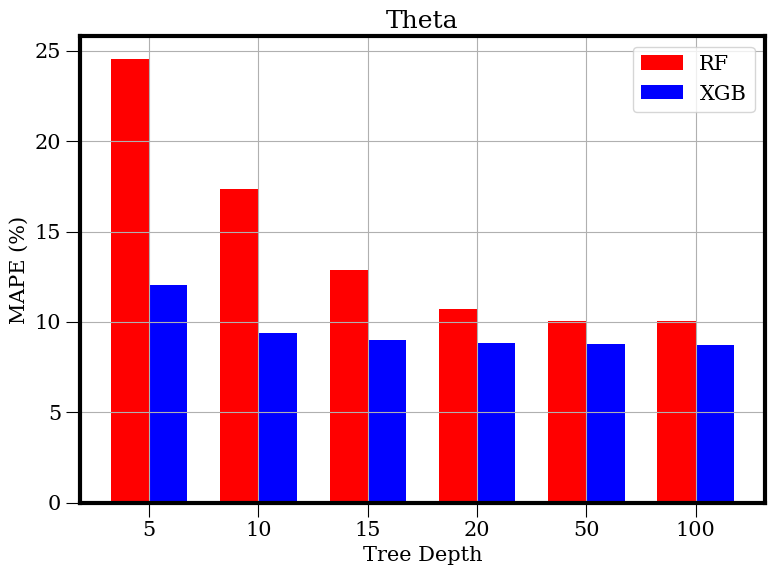

In [28]:
#performance in terms of MAPE at different tree depths
depths = max_depth_values
rf_mape = rf_mape_eval
xgb_mape = xgb_mape_eval

x = np.arange(len(depths))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))

rf_bars = ax.bar(x - width/2, rf_mape, width, label='RF', color='red')
xgb_bars = ax.bar(x + width/2, xgb_mape, width, label='XGB', color='blue')

ax.set_xlabel('Tree Depth')
ax.set_ylabel('MAPE (%)')
ax.set_title('Theta')  
ax.set_xticks(x)
ax.set_xticklabels(depths)
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

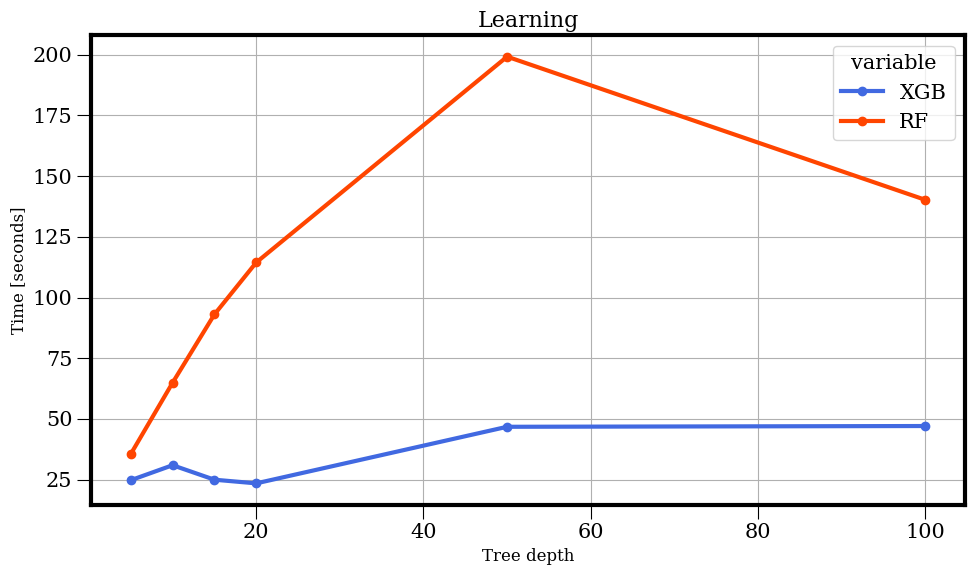

In [30]:
#plot training time
depths = max_depth_values
rf_times = rf_train_times
xgb_times = xgb_train_times

plt.figure(figsize=(10, 6))

# XGB line
plt.plot(depths, xgb_times, marker='o', label='XGB', color='royalblue')

# RF line
plt.plot(depths, rf_times, marker='o', label='RF', color='orangered')

plt.title('Learning', fontsize=16)
plt.xlabel('Tree depth', fontsize=12)
plt.ylabel('Time [seconds]', fontsize=12)
plt.legend(title='variable')
plt.grid(True)
plt.tight_layout()

plt.show()

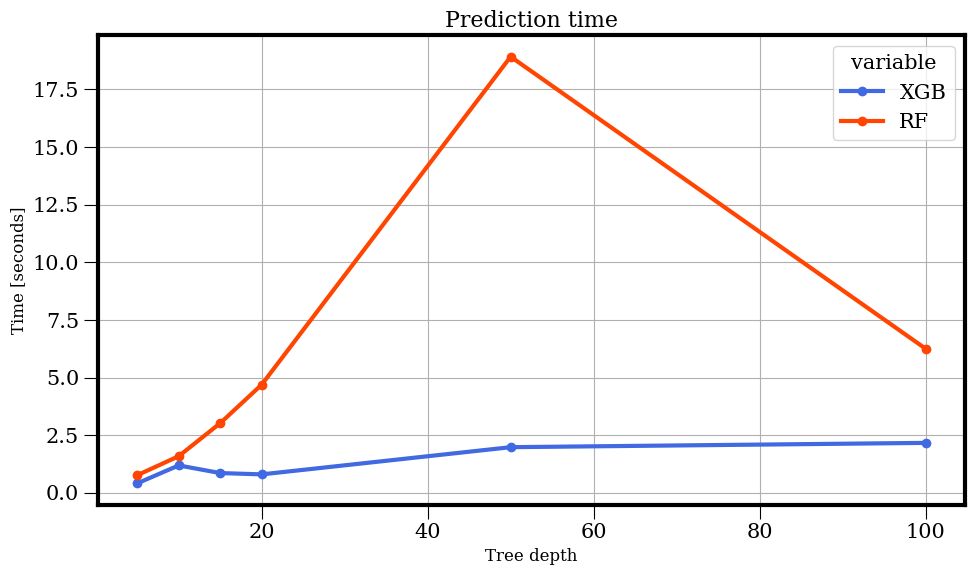

In [32]:
#plot prediction time
depths = max_depth_values
rf_times = rf_predict_times
xgb_times = xgb_predict_times

plt.figure(figsize=(10, 6))
plt.plot(depths, xgb_times, marker='o', label='XGB', color='royalblue')
plt.plot(depths, rf_times, marker='o', label='RF', color='orangered')
plt.title('Prediction time', fontsize=16)
plt.xlabel('Tree depth', fontsize=12)
plt.ylabel('Time [seconds]', fontsize=12)
plt.legend(title='variable')
plt.grid(True)
plt.tight_layout()

plt.show()

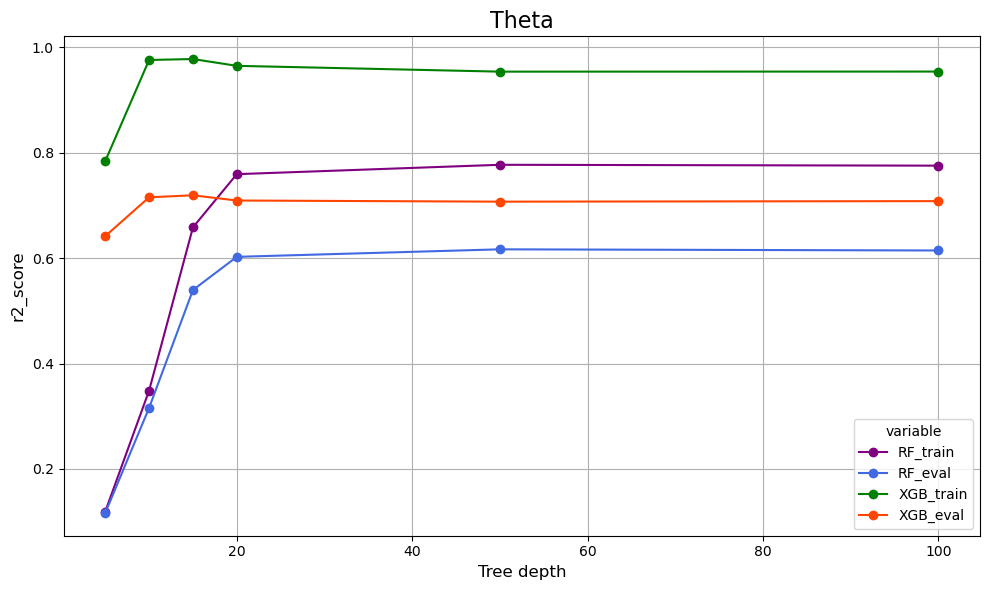

In [12]:
#plot r2_scores
depths = max_depth_values

plt.figure(figsize=(10, 6))

# rf train line
plt.plot(depths, rf_r2_scores_train, marker='o', label='RF_train', color='purple')
# rf eval line
plt.plot(depths, rf_r2_scores_eval, marker='o', label='RF_eval', color='royalblue')

# xgb train line
plt.plot(depths, xgb_r2_scores_train, marker='o', label='XGB_train', color='green')
# xgb eval line
plt.plot(depths, xgb_r2_scores_eval, marker='o', label='XGB_eval', color='orangered')

# Labels and title
plt.title('Theta', fontsize=16)
plt.xlabel('Tree depth', fontsize=12)
plt.ylabel('r2_score', fontsize=12)
plt.legend(title='variable')
plt.grid(True)
plt.tight_layout()

plt.show()

# MLP

In [86]:
# standardize the features and target variables and also reshape the target to make it suitable for neural net
sc_X = StandardScaler()
X_train_scaled = sc_X.fit_transform(X_train)
X_eval_scaled = sc_X.transform(X_eval)
X_test_scaled = sc_X.transform(X_test)
sc_y = StandardScaler()
y_train_scaled = sc_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()




In [88]:
# Define the parameter space
param_dist = {
    'hidden_layer_sizes': [(50,50), (50,), (100,), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [500, 1000,5000]
}



In [90]:
# MLP
mlp = MLPRegressor(random_state=42)

# Randomized search with 5 fold cross-validation
random_search = RandomizedSearchCV(
    mlp,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    verbose=2,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train_scaled, y_train_scaled)

# Best model
best_mlp = random_search.best_estimator_



Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, learning_rate_init=0.001, max_iter=1000, solver=sgd; total time= 1.2min
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, learning_rate_init=0.001, max_iter=5000, solver=sgd; total time= 2.5min
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, learning_rate_init=0.0001, max_iter=5000, solver=adam; total time=15.6min
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=500, solver=sgd; total time= 2.9min
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=1000, solver=sgd; total time= 3.7min
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, learning_rate_init=0.0001, max_iter=5000, solver=sgd; total time=10.0min
[CV] END activation=tanh

In [91]:
print("Best parameters found:\n", best_mlp)

Best parameters found:
 MLPRegressor(activation='tanh', alpha=0.01, hidden_layer_sizes=(100, 100),
             learning_rate_init=0.0001, max_iter=5000, random_state=42)


In [92]:
# Evaluate on training set
y_train_pred_scaled = best_mlp.predict(X_train_scaled)
y_train_pred = sc_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).ravel()

r2_train = r2_score(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
print("*** MLP evaluation on training set ***")
print(f"  R² Score: {r2_train:.4f}")
print(f"  RMSE    : {rmse_train:.4f}")
print(f"  MAE     : {mae_train:.4f}")
print(f"  MAPE    : {mape_train:.4f}")

*** MLP evaluation on training set ***
  R² Score: 0.8496
  RMSE    : 13.0421
  MAE     : 5.7762
  MAPE    : 213.7818


In [93]:
# Evaluation on evaluation set
y_eval_pred_scaled = best_mlp.predict(X_eval_scaled)
y_eval_pred = sc_y.inverse_transform(y_eval_pred_scaled.reshape(-1, 1)).ravel()

r2_eval = r2_score(y_eval, y_eval_pred)
rmse_eval = np.sqrt(mean_squared_error(y_eval, y_eval_pred))
mae_eval = mean_absolute_error(y_eval, y_eval_pred)
mape_eval = mean_absolute_percentage_error(y_eval, y_eval_pred)
print("*** MLP evaluation on evaluation set ***")
print(f"  R² Score: {r2_eval:.4f}")
print(f"  RMSE    : {rmse_eval:.4f}")
print(f"  MAE     : {mae_eval:.4f}")
print(f"  MAPE    : {mape_eval:.4f}")



*** MLP evaluation on evaluation set ***
  R² Score: 0.6753
  RMSE    : 19.3266
  MAE     : 6.5670
  MAPE    : 218.2497


In [98]:
# Predict with best model 
y_pred_scaled =best_mlp.predict(X_test_scaled)

# Inverse transform the predictions
y_test_pred = sc_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Evaluation on Test Set
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
print("*** Best MLP model, retrained and tested on test dataset ***")
print(f"  R² Score: {r2_test:.4f}")
print(f"  RMSE    : {rmse_test:.4f}")
print(f"  MAE     : {mae_test:.4f}")
print(f"  MAPE    : {mape_test:.4f}")




*** Best MLP model, retrained and tested on test dataset ***
  R² Score: 0.6491
  RMSE    : 23.8142
  MAE     : 6.6155
  MAPE    : 218.7195


# Classification

In [62]:
#Hypeparameter search for RF classifier
param_dist = {
    'n_estimators': [200, 300, 500,1000],
    'min_samples_split': [5, 10,20],
    'min_samples_leaf': [2, 4,8],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True], 
    'class_weight': ['balanced'],
    'max_samples': [0.6, 0.7, 0.8, 1.0],
    'oob_score': [True]
}

In [64]:
#reshape the target class
y_train_class = y_train_class.values.ravel() 


In [44]:
rf_clf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=rf_clf,
                                   param_distributions=param_dist,
                                   n_iter=20,
                                   cv=5,
                                   verbose=2,
                                   n_jobs=-1,
                                   random_state=42)

random_search.fit(X_train_class, y_train_class)
# Best parameters
best_classifier_params_rf = random_search.best_params_
print("Best Hyperparameters for RF Classification:\n", best_classifier_params_rf)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END bootstrap=True, class_weight=balanced, max_features=log2, max_samples=0.6, min_samples_leaf=4, min_samples_split=5, n_estimators=300, oob_score=True; total time= 1.4min
[CV] END bootstrap=True, class_weight=balanced, max_features=log2, max_samples=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=200, oob_score=True; total time= 1.1min
[CV] END bootstrap=True, class_weight=balanced, max_features=log2, max_samples=0.7, min_samples_leaf=2, min_samples_split=5, n_estimators=300, oob_score=True; total time= 1.5min
[CV] END bootstrap=True, class_weight=balanced, max_features=log2, max_samples=0.6, min_samples_leaf=4, min_samples_split=5, n_estimators=300, oob_score=True; total time= 1.4min
[CV] END bootstrap=True, class_weight=balanced, max_features=log2, max_samples=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=200, oob_score=True; total time= 1.1min
[CV] END bootstrap=True, class_weight=balanced

In [66]:
#Train with hyperparameters from random search

# List of max_depth values to try
max_depth_values = [5,10, 15, 20, 50, 100]
# Containers to store results
rf_train_times = []
rf_predict_times = []
rf_bal_acc_train = []
rf_bal_acc_eval = []
#training function for rf_classifier model
def rf_train_classifier(X,y):
    if 'max_depth' in best_classifier_params_rf:
        del best_classifier_params_rf['max_depth']
    # Loop over different max_depth values
    for depth in max_depth_values:
        print(f"\nTraining RandomForestClassifier with tree depth = {depth}")
        params = best_classifier_params_rf.copy()
        params['max_depth'] = depth
        rf = RandomForestClassifier(**params)

        # Train the model on training set
        start_train = time.time()
        rf.fit(X_train_class, y_train_class)
        end_train = time.time()
        train_duration = end_train - start_train
        rf_train_times.append(train_duration)
        print(f"Training time: {train_duration:.2f} seconds")

        # Predict and evaluate on training set
        y_train_pred = rf.predict(X_train_class)
        bal_acc_train = balanced_accuracy_score(y_train_class, y_train_pred)
        rf_bal_acc_train.append(bal_acc_train)
        print(f" Training set Balanced Accuracy: {bal_acc_train:.4f}")

        # Predict and evaluate on evaluation set
        start_test = time.time()
        y_eval_pred = rf.predict(X_eval_class)
        end_test = time.time()
        predict_duration = end_test - start_test
        rf_predict_times.append(predict_duration)
        print(f"Prediction time: {predict_duration:.2f} seconds")
        bal_acc = balanced_accuracy_score(y_eval_class, y_eval_pred)
        rf_bal_acc_eval.append(bal_acc)
        print(f"  Evaluation set Balanced Accuracy: {bal_acc:.4f}")
    

   
        #return values
    return rf_bal_acc_train, rf_bal_acc_eval
rf_train_classifier(X_train_class, y_train_class) 


Training RandomForestClassifier with tree depth = 5
Training time: 110.53 seconds
 Training set Balanced Accuracy: 0.2913
Prediction time: 3.04 seconds
  Evaluation set Balanced Accuracy: 0.2858

Training RandomForestClassifier with tree depth = 10
Training time: 174.64 seconds
 Training set Balanced Accuracy: 0.4506
Prediction time: 5.79 seconds
  Evaluation set Balanced Accuracy: 0.3721

Training RandomForestClassifier with tree depth = 15
Training time: 229.52 seconds
 Training set Balanced Accuracy: 0.7447
Prediction time: 9.60 seconds
  Evaluation set Balanced Accuracy: 0.4817

Training RandomForestClassifier with tree depth = 20
Training time: 265.56 seconds
 Training set Balanced Accuracy: 0.9031
Prediction time: 13.02 seconds
  Evaluation set Balanced Accuracy: 0.5324

Training RandomForestClassifier with tree depth = 50
Training time: 278.87 seconds
 Training set Balanced Accuracy: 0.9434
Prediction time: 15.35 seconds
  Evaluation set Balanced Accuracy: 0.5400

Training Rand

([0.29125149734362527,
  0.45056004463097427,
  0.7447148664301882,
  0.9030816880166207,
  0.9433845583347262,
  0.9432741119691378],
 [0.28582478715863835,
  0.3721408936054781,
  0.48169180491435676,
  0.5324271913945097,
  0.54002152770329,
  0.5397876582275621])

In [67]:
# Select the best depth based on evaluation balanced accuracy, and that the difference between the bal_acc score on 
# evaluation data and training data does not exceed 0.20
# Convert lists to numpy arrays 
rf_bal_acc_train = np.array(rf_bal_acc_train)
rf_bal_acc_eval = np.array(rf_bal_acc_eval)

# Compute difference between xgb_r2_scores_train and xgb_r2_scores_eval
rf_bal_acc_diff = rf_bal_acc_train - rf_bal_acc_eval
# Filter acceptable depths(difference <= 0.20)
valid_mask = rf_bal_acc_diff <= 0.20

if not np.any(valid_mask):
    print("No depths satisfy the overfitting constraint (train - eval <= 0.20).")
    print("Selecting the best depth purely based on evaluation score.")
    best_depth_index = np.argmax(rf_bal_acc_eval)
else:
    # Among valid depths, choose the one with highest eval R²
    best_depth_index = np.argmax(rf_bal_acc_eval[valid_mask])
    valid_depths = np.array(max_depth)[valid_mask]
    optimal_depth = valid_depths[best_depth_index]

print(f"\nBest max_depth that satisfies constraint: {optimal_depth}")

# Train final model with best depth
print("\nRetraining final model with best max_depth and evaluating on test data...")
best_classifier_params_rf['max_depth'] = optimal_depth
rf_final_class_model = RandomForestClassifier(**best_classifier_params_rf)
rf_final_class_model.fit(X_train_class, y_train_class)

# Predict on test set
y_test_pred = rf_final_class_model.predict(X_test_class)
rf_bal_acc_test = balanced_accuracy_score(y_test_class, y_test_pred)
print("\nFinal Test Set Evaluation:")
print(f"  Test Balanced Accuracy: {rf_bal_acc_test:.4f}")



Best max_depth that satisfies constraint: 10

Retraining final model with best max_depth and evaluating on test data...

Final Test Set Evaluation:
  Test Balanced Accuracy: 0.3720


# XGB

In [50]:
param_dist = {
 'n_estimators': [200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.5, 0.7, 0.8],
    'colsample_bytree': [0.5, 0.7, 0.8],
    'colsample_bynode': [0.5, 0.7, 1.0],
    'gamma': [0, 0.2, 0.5, 1, 2, 5],
    'min_child_weight': [1, 3, 5, 10],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2],
    'max_delta_step': [0, 1, 5],
  
}


In [52]:
# Randomized search
xgb = XGBClassifier()
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=20, 
                                   scoring='balanced_accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search.fit(X_train_class, y_train_class)

# Get best hyperparameters
best_classifier_params_xgb = random_search.best_params_
best_classifier_params_xgb

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'subsample': 0.5,
 'reg_lambda': 2,
 'reg_alpha': 0.1,
 'n_estimators': 300,
 'min_child_weight': 10,
 'max_depth': 10,
 'max_delta_step': 0,
 'learning_rate': 0.1,
 'gamma': 0.5,
 'colsample_bytree': 0.7,
 'colsample_bynode': 0.5}

In [68]:
# Get best hyperparameters
best_classifier_params_xgb = {'subsample': 0.5,
 'reg_lambda': 2,
 'reg_alpha': 0.1,
 'n_estimators': 300,
 'min_child_weight': 10,
 'max_depth': 10,
 'max_delta_step': 0,
 'learning_rate': 0.1,
 'gamma': 0.5,
 'colsample_bytree': 0.7,
 'colsample_bynode': 0.5}
best_classifier_params_xgb

{'subsample': 0.5,
 'reg_lambda': 2,
 'reg_alpha': 0.1,
 'n_estimators': 300,
 'min_child_weight': 10,
 'max_depth': 10,
 'max_delta_step': 0,
 'learning_rate': 0.1,
 'gamma': 0.5,
 'colsample_bytree': 0.7,
 'colsample_bynode': 0.5}

In [69]:
# Tree depths to test
max_depth_values = [5,10, 15, 20, 50, 100]

# Containers for results
xgb_train_times = []
xgb_predict_times = []
xgb_bal_acc_train = []
xgb_bal_acc_eval = []

def xgb_train_classifier(X,y):
    if 'max_depth' in best_classifier_params_xgb:
        del best_classifier_params_xgb['max_depth']
    # Training and evaluation loop
    for depth in max_depth_values:
        print(f"\nTraining XGBClassifier with tree depth = {depth}")
        params = best_classifier_params_xgb.copy()
        params['max_depth'] = depth

        xgb_clf = XGBClassifier(**params)

        # Train on training data
        start_train = time.time()
        xgb_clf.fit(X, y)
        end_train = time.time()
        train_time = end_train - start_train
        xgb_train_times.append(train_time)
        print(f"Training time: {train_time:.2f} seconds")

        # Predict and evaluate on training set
        print("Training Set Evaluation:")
        y_train_pred = xgb_clf.predict(X_train_class)
        bal_acc_train = balanced_accuracy_score(y_train_class, y_train_pred)
        xgb_bal_acc_train.append(bal_acc_train)
        print(f" Training set Balanced Accuracy: {bal_acc_train:.4f}")

        # Predict on evaluation set
        start_test = time.time()
        y_eval_pred = xgb_clf.predict(X_eval_class)
        end_test = time.time()
        predict_time = end_test - start_test
        xgb_predict_times.append(predict_time)
        print(f"Prediction time: {predict_time:.2f} seconds")
    
        # Evaluate performance on evaluation data
        bal_acc = balanced_accuracy_score(y_eval_class, y_eval_pred)
        xgb_bal_acc_eval.append(bal_acc)
        print("Test Set Evaluation:")
        print(f"  Balanced Accuracy: {bal_acc:.4f}")

        #return values
    return xgb_bal_acc_train, xgb_bal_acc_eval
xgb_train_classifier(X_train_class, y_train_class)     


Training XGBClassifier with tree depth = 5
Training time: 16.38 seconds
Training Set Evaluation:
 Training set Balanced Accuracy: 0.2903
Prediction time: 0.25 seconds
Test Set Evaluation:
  Balanced Accuracy: 0.2721

Training XGBClassifier with tree depth = 10
Training time: 20.35 seconds
Training Set Evaluation:
 Training set Balanced Accuracy: 0.5588
Prediction time: 0.65 seconds
Test Set Evaluation:
  Balanced Accuracy: 0.4044

Training XGBClassifier with tree depth = 15
Training time: 39.19 seconds
Training Set Evaluation:
 Training set Balanced Accuracy: 0.6989
Prediction time: 1.34 seconds
Test Set Evaluation:
  Balanced Accuracy: 0.4536

Training XGBClassifier with tree depth = 20
Training time: 44.56 seconds
Training Set Evaluation:
 Training set Balanced Accuracy: 0.7378
Prediction time: 1.51 seconds
Test Set Evaluation:
  Balanced Accuracy: 0.4632

Training XGBClassifier with tree depth = 50
Training time: 50.84 seconds
Training Set Evaluation:
 Training set Balanced Accurac

([0.29031618204359955,
  0.5588240243310969,
  0.6989288664263558,
  0.7377774099923621,
  0.748140960702862,
  0.748140960702862],
 [0.27210777484466764,
  0.40444667436039927,
  0.45360901943543896,
  0.4631777266176969,
  0.4673190811743864,
  0.4673190811743864])

In [70]:
# Select the best depth based on evaluation balanced accuracy, and that the difference between the bal_acc score on 
# evaluation data and training data does not exceed 0.20
# Convert lists to numpy arrays 
xgb_bal_acc_train = np.array(xgb_bal_acc_train)
xgb_bal_acc_eval = np.array(xgb_bal_acc_eval)

# Compute difference between xgb_r2_scores_train and xgb_r2_scores_eval
xgb_bal_acc_diff = xgb_bal_acc_train - xgb_bal_acc_eval
# Filter acceptable depths(difference <= 0.20)
valid_mask = xgb_bal_acc_diff <= 0.20

if not np.any(valid_mask):
    print("No depths satisfy the overfitting constraint (train - eval <= 0.20).")
    print("Selecting the best depth purely based on evaluation score.")
    best_depth_index = np.argmax(xgb_bal_acc_eval)
else:
    # Among valid depths, choose the one with highest eval R²
    best_depth_index = np.argmax(xgb_bal_acc_eval[valid_mask])
    valid_depths = np.array(max_depth)[valid_mask]
    optimal_depth = valid_depths[best_depth_index]

print(f"\nBest max_depth that satisfies constraint: {optimal_depth}")

# Train final model with best depth
print("\nRetraining final XGB model with best max_depth and evaluating on test data...")
best_params['max_depth'] = optimal_depth
xgb_final_class_model = XGBClassifier(**best_classifier_params_xgb)
xgb_final_class_model.fit(X_train_class, y_train_class)

# Predict on test set
y_test_pred = xgb_final_class_model.predict(X_test_class)
xgb_bal_acc_test = balanced_accuracy_score(y_test_class, y_test_pred)
print("\nFinal Test Set Evaluation:")
print(f"  Test Balanced Accuracy: {xgb_bal_acc_test:.4f}")



Best max_depth that satisfies constraint: 10

Retraining final XGB model with best max_depth and evaluating on test data...

Final Test Set Evaluation:
  Test Balanced Accuracy: 0.2993


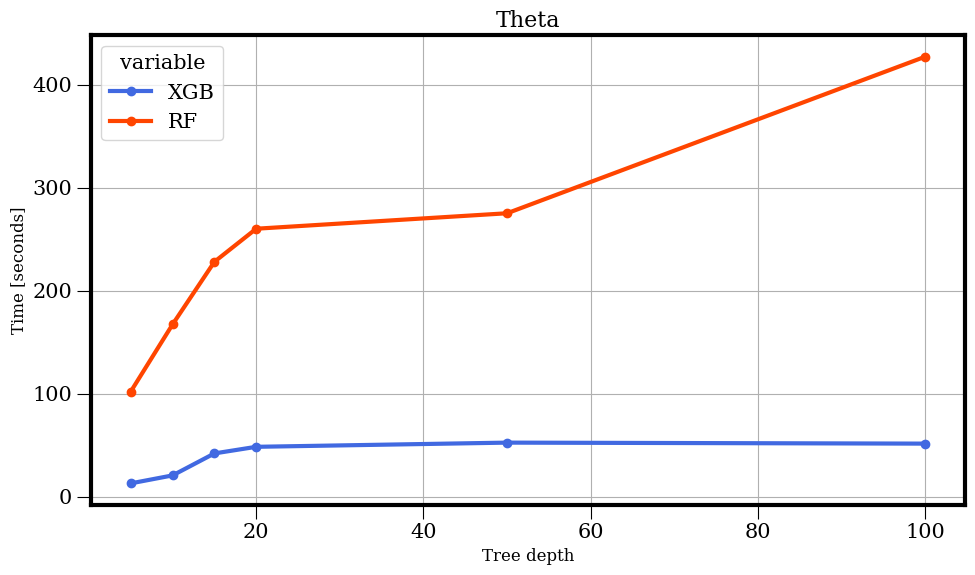

In [61]:
#plot training time
depths = max_depth_values
rf_times = rf_train_times
xgb_times = xgb_train_times

plt.figure(figsize=(10, 6))

# XGB line
plt.plot(depths, xgb_times, marker='o', label='XGB', color='royalblue')

# RF line
plt.plot(depths, rf_times, marker='o', label='RF', color='orangered')

# Labels and title
plt.title('Theta', fontsize=16)
plt.xlabel('Tree depth', fontsize=12)
plt.ylabel('Time [seconds]', fontsize=12)
plt.legend(title='variable')
plt.grid(True)
plt.tight_layout()

plt.show()

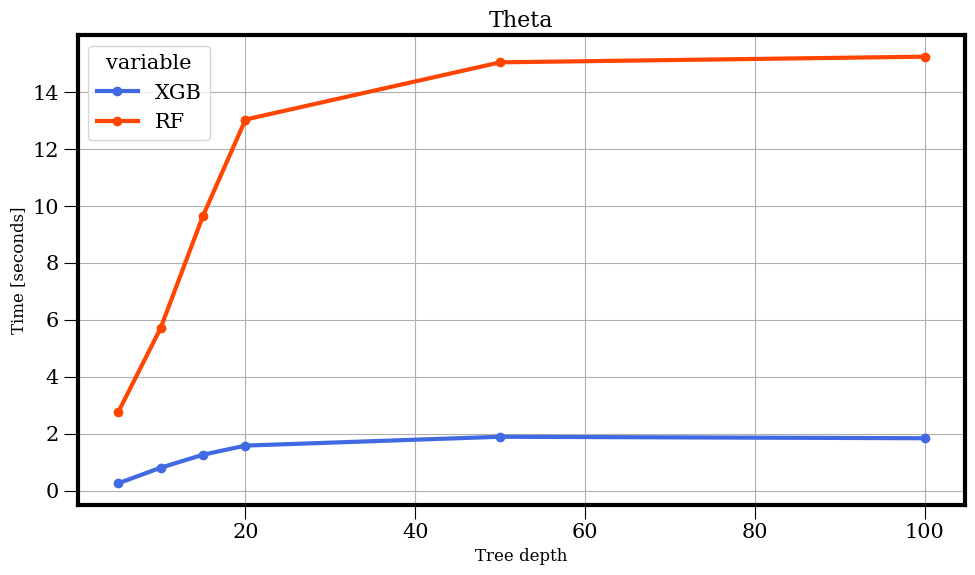

In [62]:
#plot prediction time
depths = max_depth_values
rf_times = rf_predict_times
xgb_times = xgb_predict_times

plt.figure(figsize=(10, 6))

# XGB line
plt.plot(depths, xgb_times, marker='o', label='XGB', color='royalblue')

# RF line
plt.plot(depths, rf_times, marker='o', label='RF', color='orangered')

# Labels and title
plt.title('Theta', fontsize=16)
plt.xlabel('Tree depth', fontsize=12)
plt.ylabel('Time [seconds]', fontsize=12)
plt.legend(title='variable')
plt.grid(True)
plt.tight_layout()

plt.show()

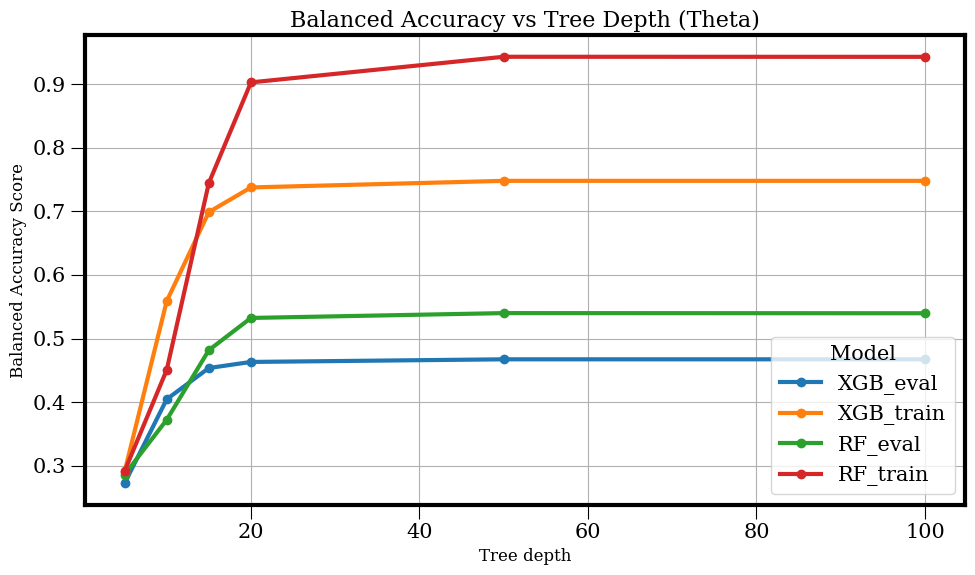

In [71]:
# Plot balanced accuracy
depths = max_depth_values

plt.figure(figsize=(10, 6))
# XGB
plt.plot(depths, xgb_bal_acc_eval, marker='o', label='XGB_eval')
plt.plot(depths, xgb_bal_acc_train, marker='o', label='XGB_train')
# RF
plt.plot(depths, rf_bal_acc_eval, marker='o', label='RF_eval')
plt.plot(depths, rf_bal_acc_train, marker='o', label='RF_train')
plt.title('Balanced Accuracy vs Tree Depth (Theta)', fontsize=16)
plt.xlabel('Tree depth', fontsize=12)
plt.ylabel('Balanced Accuracy Score', fontsize=12)
plt.legend(title='Model')
plt.grid(True)
plt.tight_layout()

plt.show()

# MLP

In [135]:
# Standardize input features for classification(important for MLPs)
sc_X = StandardScaler()
X_train_class_scaled = sc_X.fit_transform(X_train_class)
X_eval_class_scaled = sc_X.transform(X_eval_class)
X_test_class_scaled = sc_X.transform(X_test_class)

#reshape the target
y_train_class = y_train_class.values.ravel() 
y_eval_class = y_eval_class.values.ravel()
y_test_class = y_test_class.values.ravel()

In [147]:
# Define hyperparameter search space
param_dist = {
   'hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128],
    'max_iter': [500,1000,2000,5000],
}

In [149]:
#Setup MLPClassifier and hyperparameter tuning
mlp_clf = MLPClassifier(random_state=42, early_stopping=True)

random_search_clf = RandomizedSearchCV(
    mlp_clf,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
random_search_clf.fit(X_train_class_scaled, y_train_class)

# Get the best estimator
best_clf = random_search_clf.best_estimator_
print("\nBest Hyperparameters:")
print(random_search_clf.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Hyperparameters:
{'solver': 'adam', 'max_iter': 2000, 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (128, 64), 'batch_size': 32, 'alpha': 0.001, 'activation': 'tanh'}


In [150]:
# Evaluate on training dataset
y_train_pred = best_clf.predict(X_train_class_scaled)
acc_train = balanced_accuracy_score(y_train_class, y_train_pred)
print(f"Training Set Balanced Accuracy: {acc_train:.4f}")


Training Set Balanced Accuracy: 0.3107


In [151]:
# Evaluate on evaluation data
y_eval_pred = best_clf.predict(X_eval_class_scaled)
acc_eval = balanced_accuracy_score(y_eval_class, y_eval_pred)
print(f"Evaluation Set Balanced Accuracy: {acc_eval:.4f}")


Evaluation Set Balanced Accuracy: 0.2867


In [152]:
# Evaluate on test data
y_test_pred = best_clf.predict(X_test_class_scaled)
acc_test = balanced_accuracy_score(y_test_class, y_test_pred)
print(f"Test Set Balanced Accuracy: {acc_test:.4f}")

Test Set Balanced Accuracy: 0.2909
